# 注意，需要预先创建以下目录和文件
`../glove/glove.6B.100d.txt`：下载地址：<http://nlp.stanford.edu/data/glove.6B.zip>

# import
0. 读取数据、矩阵计算、路径计算等基础库
--------
1. 正则去标点等+大小写
2. 空格分词+去停用词
3. 词形统一
3. tf-idf编码方式
--------
4. 模型：使用keras自己构建CNN
5. 分析：混淆矩阵、准确率预测、训练耗时
6. 保存模型
## 改进点
- GPU加速
- 其他模型
- 参数
- 结果显示
- 函数封装

In [1]:
import csv
import numpy as np


import nltk
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

import time

Using TensorFlow backend.


# 读取数据集
使用csv读取文本文件，得到二维列表

In [2]:
"""获取原始数据"""
file_path = '../smsspamcollection/SMSSpamCollection'
smsFile = open(file_path, 'r', encoding='utf-8') ## 返回文件对象
sms = csv.reader(smsFile, delimiter='\t') ## 第一层：行列表；第二层：列列表
sms = list(sms) 
smsFile.close()
"""显示原始数据"""
for line in sms[0:3]:
    print(line)

['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']
['ham', 'Ok lar... Joking wif u oni...']
['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]


# 预处理
## 定义预处理

In [3]:
def regUse(text):
    text = re.sub(r"[,.?!\":]", '', text) # 去标点
    text = re.sub(r"'\w*\s", ' ', text) # 去缩写
    text = re.sub(r"#?&.{1,3};", '', text) # 去html符号
    return text.lower()
def sampleSeg(text):
    tokens = [word for word in word_tokenize(text) if word not in stopwords.words('english') and len(word)>=3]
    return tokens
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
def lemSeg(tokens):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(tokens):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res
def preprocess(text):
    text = regUse(text)
    tokens = sampleSeg(text)
    tokens = lemSeg(tokens)
    return tokens ## 返回的是单词列表

## 实施预处理

In [4]:
sms_data = [] ## 每个元素是一个句子
sms_label = [] ## 每个元素是一个字符串0/1
label_num = {"spam":1, "ham":0} ## 垃圾邮件为1，正常邮件为0

start = time.perf_counter()
for line in sms:
    sms_data.append(" ".join(preprocess(line[1])))
    sms_label.append(label_num[line[0]])
elapsed = (time.perf_counter() - start)
print("预处理耗时:{:.2f}s".format(elapsed))
"""显示预处理结果"""
print("预处理后的结果示例：")
print(sms_data[0:3])
print(sms_label[0:3])

预处理耗时:22.50s
预处理后的结果示例：
['jurong point crazy available bugis great world buffet cine get amore wat', 'lar joking wif oni', 'free entry wkly comp win cup final tkts 21st may 2005 text 87121 receive entry question std txt rate apply 08452810075over18']
[0, 0, 1]


# 准备训练集、验证集

In [5]:
MAX_NUM_WORDS = 2000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) ## 最终选取频率前MAX_NUM_WORDS个单词
tokenizer.fit_on_texts(sms_data)
MAX_SEQUENCE_LENGTH = 50 ## 长度超过MAX_SEQUENCE_LENGTH则截断，不足则补0
sequences = tokenizer.texts_to_sequences(sms_data) ## 是一个二维数值数组，每一个数值都是对应句子对应单词的**索引**
dataset = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) 
labels = to_categorical(np.asarray(sms_label)) ## 将label转为独热编码形式

"""打乱"""
indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]

"""划分"""
size_dataset = len(dataset)
size_trainset = int(round(size_dataset*0.7))
print("训练集大小：{}".format(size_trainset))
print("验证集大小：{}".format(size_dataset - size_trainset))
x_train = dataset[0:size_trainset]
y_train = labels[0:size_trainset]

x_val = dataset[size_trainset+1: size_dataset]
y_val = labels[size_trainset+1: size_dataset]

训练集大小：3900
验证集大小：1672


# 构建模型
## 构建embedding层
### 1.准备预训练好的词典

In [6]:
embedding_dic = {}
file_path = '../glove/glove.6B.100d.txt'

start = time.perf_counter()
with open(file_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_dic[word] = coefs
        
elapsed = (time.perf_counter() - start)
print("准备词典耗时:{:.2f}s".format(elapsed))

准备词典耗时:11.11s


### 2.准备embedding_matrix
embedding_matrix是本文中所有（或者选取高频部分）单词对应的词向量

In [7]:
"""选取部分单词"""
word_index = tokenizer.word_index ## 得到一个字典，key是选择的单词，value是它的索引

print("共有{}个单词，示例：".format(len(word_index)))
print(list(word_index.keys())[0:5], list(word_index.values())[0:5]) 

"""准备这些单词的embedding_matrix"""
EMBEDDING_DIM = 100 ## 令词向量的维度是100
num_words = min(MAX_NUM_WORDS, len(word_index) + 1) ## 为什么要加一？
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

start = time.perf_counter()
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_dic.get(word)
    if embedding_vector is not None: ## 单词在emmbeding_dic中存在时
        embedding_matrix[i] = embedding_vector
elapsed = (time.perf_counter() - start)
print("准备embedding_matrix耗时:{:.2f}s".format(elapsed))        

共有8180个单词，示例：
['get', 'call', 'come', 'free', 'know'] [1, 2, 3, 4, 5]
准备embedding_matrix耗时:0.00s


### 3.构建embedding layer

In [8]:
embedding_layer = Embedding(input_dim=num_words,  # 词汇表单词数量
                            output_dim=EMBEDDING_DIM,  # 词向量维度
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)  # 词向量矩阵不进行训练

W0708 09:13:15.549052  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



## 构建、连接其他层

In [9]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')  # 占位。
embedded_sequences = embedding_layer(sequence_input)  # 返回 句子个数*50*100
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(label_num), activation='softmax')(x)
 
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

W0708 09:13:39.478199  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 09:13:39.481159  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 09:13:39.488139  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 09:13:39.489148  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0708 09:13:39.533020  1464 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
__________

# 应用模型

In [12]:
model.fit(x_train, y_train, batch_size=16, epochs=5, validation_data=(x_val, y_val))

Train on 3900 samples, validate on 1671 samples
Epoch 1/5
3900/3900 [==============================] - 2s 444us/step - loss: 0.0704 - acc: 0.9862 - val_loss: 0.3277 - val_acc: 0.9539
Epoch 2/5
3900/3900 [==============================] - 2s 435us/step - loss: 0.0838 - acc: 0.9862 - val_loss: 0.4469 - val_acc: 0.9515
Epoch 3/5
3900/3900 [==============================] - 2s 455us/step - loss: 0.0905 - acc: 0.9849 - val_loss: 0.3406 - val_acc: 0.9563
Epoch 4/5
3900/3900 [==============================] - 2s 463us/step - loss: 0.0635 - acc: 0.9882 - val_loss: 0.4509 - val_acc: 0.9551
Epoch 5/5
3900/3900 [==============================] - 2s 465us/step - loss: 0.0977 - acc: 0.9836 - val_loss: 0.4105 - val_acc: 0.9545


# 显示性能指标
## 1.格式转换函数

In [34]:
"""将y_val转为y_val_label"""
# y_val[0:3]示例：[[0. 1.]
#                 [1. 0.]
#                 [1. 0.]]
# y_val_label[0:3]示例：['spam' 'ham' 'ham']
def TOy_val_label(y_val):
    y_val_label = []
    spam = np.array([0., 1.]) ## [0 1]表示垃圾邮件？
    ham = np.array([1., 0.]) ## [1 0]表示正常邮件
    for line in y_val:
        if all(line == spam):
            y_val_label.append("spam")
        else:
            y_val_label.append("ham")
    
    y_val_label = np.array(y_val_label)
    return y_val_label
"""将y_pred转为y_pred_label"""
# y_pred[0:3]示例：[[9.9905199e-01 9.4802002e-04]
#                  [9.8692465e-01 1.3075325e-02]
#                  [1.0000000e+00 0.0000000e+00]]
# y_pred_label[0:3]示例：['ham' 'ham' 'ham']
def TOy_pred_label(y_pred):
    y_pred_label = []
    y_pred_index = np.argmax(y_pred, axis=1)

    for line in y_pred_index:
        if line == 0:
            y_pred_label.append("ham")
        else:
            y_pred_label.append("spam")
    
    y_pred_label = np.array(y_pred_label)
    return y_pred_label

## 2.性能显示函数

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

def show_model(y_val_label, y_pred_label):
    cm = confusion_matrix(y_val_label, y_pred_label)
    cr = classification_report(y_val_label, y_pred_label)
    print('混淆矩阵：')
    print(cm)
    print('分类结果：')
    print(cr)


def print_AUC(y_val_label, y_pred):
    y_scores = y_pred[:, 1]
    fpr,tpr,threshold = roc_curve(y_val_label, y_scores, pos_label='spam')
    roc_auc = auc(fpr,tpr)
    
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## 3.开始评估

混淆矩阵：
[[1429   18]
 [  58  166]]
分类结果：
              precision    recall  f1-score   support

         ham       0.96      0.99      0.97      1447
        spam       0.90      0.74      0.81       224

   micro avg       0.95      0.95      0.95      1671
   macro avg       0.93      0.86      0.89      1671
weighted avg       0.95      0.95      0.95      1671



<Figure size 432x288 with 0 Axes>

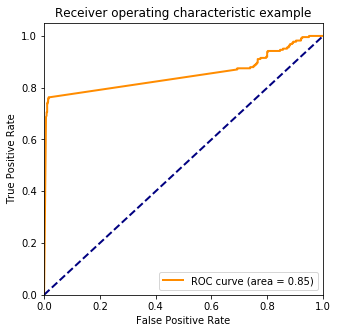

In [40]:
y_pred = model.predict(x_val,batch_size = 16)
y_val_label = TOy_val_label(y_val)
y_pred_label = TOy_pred_label(y_pred)
show_model(y_val_label, y_pred_label)
print_AUC(y_val_label, y_pred)